# Orbital Mechanics for a Solar Sail

This notebook was created for the simulation of a solar sail in various orbital systems.



## Imports

There are various libraries that must be imported for the simulation of coupled ODEs

In [1]:
from scipy.integrate import odeint
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from pycvodes import integrate_predefined
import scipy.fft as fft

## Universal Constants

There are some universal constants which remain the same no matter the system and we define them here at a top level for future use.

In [2]:
G_CONSTANT = 6.67e-11
C_CONSTANT = 299792458
L0_CONSTANT = 3.83e26
SOLAR_MASS_CONSTANT = 1.99e30
EARTH_MASS_CONSTANT = 5.97e24
MARS_MASS_CONSTANT = 6.39e23

## Sail Parameters

For our sail, we consider common design trends and come up with parameters based on these for three different designs. The first being a small 'concept' sail, a larger sail for interplanetary travel and an even larger sail for interstellar travel. 
* In terms of reflectivity, most sails use an aluminium layer of thickness 20 nm or more. This achieves a reflectivity of between 0.88 and 0.9. Thus we base our parameter for the concept and interplanetary designs on the average of these two. I.e. 0.89. For the interstellar vehicle, we assume some progress in technology and thus aim for a reflectivity of 0.95.
* For area and mass. We consider their ratio. The IKAROS mission had a mass of 315 kg, an area of 14x14 metres and thus a ratio of 196:315 so we use this for the concept sail. For interstellar designs a ratio of 12960:1 is cited by Robert L. Forward. Thus, for the interplanetary sail we take a value imbetween these of 1000:1.


In [3]:
concept_sail_reflectivity = 0.89
planetary_sail_reflectivity = 0.89
stellar_sail_reflectivity = 0.95

concept_sail_mass_to_area = 1/0.622
planetary_sail_mass_to_area = 1/1000
stellar_sail_mass_to_area = 1/12960

## 2 Bodies: Sun and Sail

For this our two equations are as follows:

$$\ddot r = r \dot \theta^2 + \frac{G M}{r^2} + \frac{\left(1 + R \cos(2 \phi) \right) L_0 A}{4 c m \pi r^2} \cos(\phi)$$

$$\ddot \theta = - \frac{2 \dot r \dot \theta}{r} - \frac{R \sin(2 \phi) L_0 A}{4 c \pi m r^3} \cos(\phi)$$

However, we group parameters in such a way by setting:

$$\tau = t_c t, \text{ where: } t_c = 31536000 \\$$
$$\tilde{r} = r_c r, \text{ where: } r_c = 1.495978707 \cdot 10^{11}$$ 

So as to produce:

$$\tilde{r}^2 \frac{d^2 \tilde{r}}{d \tau^2} = \tilde{r}^3 \left(\frac{d \theta}{d \tau}\right)^2 + \alpha \sigma \left(1 + R \cos(2 \phi) \right) \cos(\phi) + \beta $$
$$\tilde{r}^3 \frac{d^2 \theta}{d \tau^2} = - 2 \tilde{r}^2 \frac{d \tilde{r}}{d \tau} \frac{d \theta}{d \tau} - \alpha \sigma R \sin(2 \phi) \cos(\phi)$$

Where:

$$\alpha = \frac{t_c^2}{r_c^3} \frac{L_0}{4 c \pi}$$
$$\beta = \frac{t_c^2}{r_c^3} GM$$
$$\sigma = \frac{m}{A}$$

In [4]:
ts = 365 * 24 * 60 * 60
rs = 1.495978707e11

In [5]:
alpha = ((ts**2)/(rs**3)) * (L0_CONSTANT / (4 * C_CONSTANT * math.pi))
print(alpha)
beta = ((ts**2)/(rs**3)) * G_CONSTANT * SOLAR_MASS_CONSTANT
print(beta)

0.03019987773807573
39.429011388749956


In [6]:
def sunAndSailODEs(y,t,R,sigma,phi):
    r = y[0]
    rdot = y[1]
    theta = y[2]
    thetadot = y[3]
    
    rddot = r * (thetadot**2) + r**(-2) * (alpha / sigma) * (1 + R * np.cos(2 * phi)) * np.cos(phi) - (beta / r**2)
    thetaddot = ((-2)/r) * rdot * thetadot - r**(-3) * (alpha / sigma) * R * np.sin(2 * phi) * np.cos(phi)
    
    return [rdot, rddot, thetadot, thetaddot]

def limitingODEs(y,t):
    r = y[0]
    rdot = y[1]
    theta = y[2]
    thetadot = y[3]
    
    rddot = r * (thetadot**2) - (beta / r**2)
    thetaddot = ((-2)/r) * rdot * thetadot
    
    return [rdot, rddot, thetadot, thetaddot]

### Initial Conditions and Arguments

We have our concept solar sail initially going around the sun at Earth's orbital radius with an initial velocity equivalent to that of the planet. 

In [7]:
r0, rdot0, theta0, thetadot0 = 1, 0, 0, 2 * math.pi
y0 = [r0,rdot0,theta0,thetadot0]

### Solving ODEs

To solve the ODEs we use a function called odeint from the scipy library

In [47]:
t = np.linspace(0, 5,1000)

y,info = odeint(sunAndSailODEs, y0,t, args=(0.9, 5e-3,(-1/8) * np.pi), full_output=1) #printmessg=True, full_output=True
y1,info1 = odeint(limitingODEs, y0,t, full_output=1)

r, rdot, theta, thetadot = y[:,0], y[:,1], y[:,2], y[:,3]
r1, rdot1, theta1, thetadot1 = y1[:,0], y1[:,1], y1[:,2], y1[:,3]

### Plotting Solution

We convert back to cartesian to plot the results.

In [48]:
def polarToCartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return(x, y)

(x,y) = polarToCartesian(r,theta)
(x1,y1) = polarToCartesian(r1,theta1)

### Plotting Orbital Radius as a Function of Time

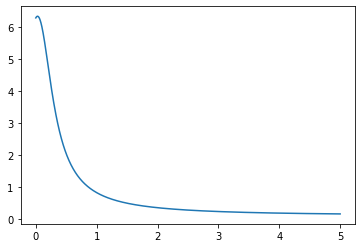

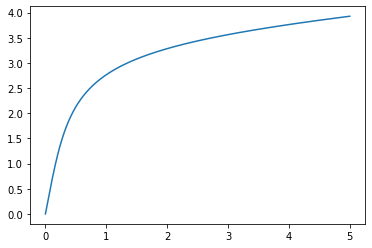

In [49]:
# fig = plt.plot(t,r)
plt.plot(t, thetadot)
plt.show()

plt.plot(t, theta)
plt.show()

### Plotting Orbit of Sail

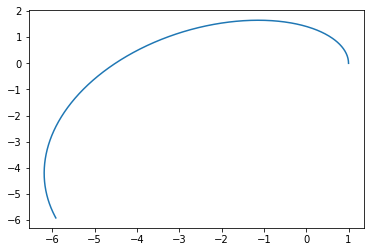

In [50]:
fig = plt.plot(x,y)
plt.show()

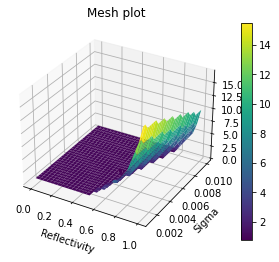

In [117]:
t = np.linspace(0, 10,10000)

grain = 30

R_array = np.linspace(1,0,grain)
sigma_array = np.linspace(1e-3,10e-3, grain)
results = np.arange(grain*grain).reshape(grain,grain)

for i, R_value in enumerate(R_array):
    for j, sigma_value in enumerate(sigma_array):
        solution = odeint(sunAndSailODEs, y0,t, args=(R_value, sigma_value,0))
        r, rdot, theta, thetadot = solution[:,0], solution[:,1], solution[:,2], solution[:,3]
        results[i][j] = r[2*1000]

fig = plt.figure()
ax = plt.axes(projection='3d')

X,Y = np.meshgrid(R_array, sigma_array)

surf = ax.plot_surface(X, Y, results, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0, antialiased=True)

# Add a color bar which maps values to colors.
fig.colorbar(surf)
plt.title("Mesh plot")
plt.xlabel("Reflectivity")
plt.ylabel("Sigma")
# plt.zlabel("Radius after 2 years")
plt.show()

## 4 Bodies: Sun, Earth, Mars and Sail

### Generating Function for ODEs

Below we wish to create a function which can produce arbitrarily many additional planets and model them idnividually.

In [137]:
def polarDistance(r1,r2,theta1,theta2):
    return math.sqrt(r1**2 + r2**2 - 2 * r1 * r2 * math.cos(theta1 - theta2))

def g1(r1,r2,theta1,theta2):
    return ((2*r1 - r2 * math.cos(theta1-theta2)) / ((r1**2 + r2**2 - 2 * r1 * r2 * \
            math.cos(theta1 - theta2))**(3/2)))

def g2(r1,r2,theta1,theta2):
    return (r2 * math.sin(theta1 - theta2)) / (r1*(r1**2 + r2**2 - 2 * r1 * r2 * \
            math.cos(theta1 - theta2))**(3/2))

In [138]:
beta_1 = (ts**2)/(rs**3) * G_CONSTANT * SOLAR_MASS_CONSTANT
beta_2 = (ts**2)/(rs**3) * G_CONSTANT * EARTH_MASS_CONSTANT
beta_3 = (ts**2)/(rs**3) * G_CONSTANT * MARS_MASS_CONSTANT

In [175]:
def fourBodyODEs(x,t,R,area_to_mass,phi):
    r = x[0]
    r_dot = x[1]
    theta = x[2]
    theta_dot = x[3]
    r_e = x[4]
    r_e_dot = x[5]
    theta_e = x[6]
    theta_e_dot = x[7]
    r_m = x[8]
    r_m_dot = x[9]
    theta_m = x[10]
    theta_m_dot = x[11]

    r_ddot = r * theta_dot**2 +  - (beta_1) /r**2 - beta_2 * g1(r,r_e,theta,theta_e) - beta_3 * g1(r,r_m,theta,theta_m) \
                + (r**(-2)) * (alpha / sigma) * (1 + R * np.cos(2 * phi)) * np.cos(phi)
    
    theta_ddot = (-2/r) * r_dot * theta_dot - beta_2 * g2(r, r_e, theta, theta_e) - beta_3 * g2(r,r_m,theta,theta_m) \
                - (r**(-3)) * (alpha / sigma) * R * np.sin(2 * phi) * np.cos(phi)
    
    r_e_ddot = r_e * (theta_e_dot)**2 - beta_1 / r**2 - beta_3 * g1(r_e, r_m, theta_e, theta_m)
    
    theta_e_ddot = - (2 / r_e) * r_e_dot * theta_e_dot - beta_3 * g2(r_e,r_m,theta_e,theta_m)
    
    r_m_ddot = r_m * (theta_m_dot)**2 - beta_1 / r**2 - beta_2 * g1(r_m, r_e, theta_m, theta_e)
    
    theta_m_ddot = - (2 / r_m) * r_m_dot * theta_m_dot - beta_2 * g2(r_m,r_e,theta_m,theta_e)
    
    
    return [r_dot, r_ddot, theta_dot, theta_ddot, r_e_dot, r_e_ddot, theta_e_dot, theta_e_ddot, \
           r_m_dot, r_m_ddot, theta_m_dot, theta_m_ddot]

In [176]:
t = np.linspace(0, 5,100000)

r0, rdot0, theta0, thetadot0 = 0.7, 0, 0, 3 * math.pi
r_e0, r_e_dot0, theta_e0, theta_e_dot0 = 1, 0, 0, 2 * math.pi
r_m0, r_m_dot0, theta_m0, theta_m_dot0 = 1.5237, 0, 0, 1.882 * 2 * math.pi

y0 = [r0, rdot0, theta0, thetadot0, r_e0, r_e_dot0, theta_e0, theta_e_dot0, \
     r_m0, r_m_dot0, theta_m0, theta_m_dot0]

y,info = odeint(fourBodyODEs, y0,t, args=(0.9, 5e-3,(-1/8) * np.pi), full_output=1)

r_s, r_dot_s, theta_s, theta_dot_s = y[:,0], y[:,1], y[:,2], y[:,3]
r_e, r_dot_e, theta_e, theta_dot_e = y[:,4], y[:,5], y[:,6], y[:,7]
r_m, r_dot_m, theta_m, theta_dot_m = y[:,8], y[:,9], y[:,10], y[:,11]

print(r_e)

[1.         0.99999995 0.9999998  ... 1.49256596 1.49252407 1.49248218]


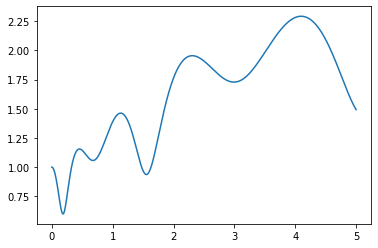

In [174]:
plt.plot(t, r_e)